# Created my own model 
## Inspired by Dilated Net and Large Kernel Matters Papers
### Uses Large Kernels at the Ending layers
### Uses Dilated Convolutions and Transposed Convolutions
### Reduces False Positives to a great extent
### Best results on test set among all trained models
### The test outputs are shown below
### The model is pretrained on existing set and then finetuned on augmented data
### The model is overfitted on existing set and then finetuned on augumented data
### The output contains the smoothed output and thresholded output with the test image

#### Do not run the code ! 

In [58]:
cv2.imread(bgImgPath)
from keras.models import Model, Sequential
from keras.layers import *
import numpy as np
import keras.backend as K
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('tf')
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Dropout, merge
import numpy as np
import keras.backend as K
from keras.optimizers import *
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.layers import concatenate,Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('tf')
from keras.callbacks import ModelCheckpoint
train = np.load('/home/ubuntu/MobileExtraction/Train256x324-full.npy')
labels = np.load('/home/ubuntu/MobileExtraction/Labels256x324-full.npy')
x = np.argwhere(labels>0)
print(x.shape)
for i in range(x.shape[0]):
    labels[x[i][0],x[i][1],x[i][2]] = 1
train = train.reshape(train.shape[0],256,324,1)
#labels = labels.reshape(347,256,324,1)
labels = to_categorical(labels)
print(np.unique(labels))
import tensorflow as tf
print(labels.shape)
print(train.shape)
labels=labels.astype('uint8')
smooth = 1.
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=1)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred)-K.log(dice_coef(y_true, y_pred))

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - inmooth = 1.
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_detersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
inputs = Input((256*2,324*2,1))
x = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(inputs)
x1 = Conv2D(filters=64,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = MaxPooling2D(pool_size=(2,2))(x1)
x = Conv2D(filters=128,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x2 = Conv2D(filters=128,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = MaxPool2D(pool_size=(2,2))(x2)
x = Conv2D(filters=256,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=256,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=256,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=256,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',kernel_initializer='he_normal')(x),x2])
x = Conv2D(filters=128,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=128,activation='relu',kernel_size=(3,3),padding='same',kernel_regularizer=l2(1e-4))(x)
x = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',kernel_initializer='he_normal')(x),x1])
x = Conv2D(filters=64,activation='relu',kernel_size=(1,1),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=64,activation='relu',kernel_size=(1,1),padding='same',kernel_regularizer=l2(1e-4))(x)
x = Conv2D(filters=2,activation='softmax',kernel_size=(1,1),padding='same')(x)
model = Model(inputs=inputs,outputs=x)

(2217853, 3)
[0. 1.]
(394, 256, 324, 2)
(394, 256, 324, 1)


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


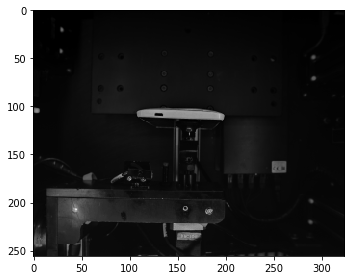

array([0, 1], dtype=uint8)

In [59]:
from skimage import io
io.imshow(train[33,:,:,0])
io.show()
np.unique(labels)

In [60]:
model.compile(optimizer=RMSprop(lr=1e-7,decay=1e-8), loss=bce_dice, metrics=[dice_coef,jacard_coef])

In [61]:
checkpoint = ModelCheckpoint(filepath='/home/ubuntu/MobileExtraction/dilated512-run6.h5',mode='max',
                             monitor='val_dice_coef',verbose=1,save_best_only=True)
model.load_weights('/home/ubuntu/MobileExtraction/dilated512-run6.h5')
'''data_gen_args = dict(horizontal_flip=True,vertical_flip=True,
                     rotation_range=90.,
                     shear_range=0.2,height_shift_range=0.2,width_shift_range=0.2
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
mooth = 1.
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_de
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train, seed=seed)


# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow(x=train[:40],batch_size=1,seed=1), mask_datagen.flow(x=labels[:40],batch_size=1,seed=1))
valid_generator = zip(image_datagen.flow(x=train[70:],batch_size=1,seed=1), mask_datagen.flow(x=labels[70:],batch_size=1,seed=1))
model.fit_generator(callbacks=[checkpoint],validation_data=[train[40:],labels[40:]],validation_steps=90,
    generator=train_generator,
    steps_per_epoch=2000,
    epochs=100)'''

'data_gen_args = dict(horizontal_flip=True,vertical_flip=True,\n                     rotation_range=90.,\n                     shear_range=0.2,height_shift_range=0.2,width_shift_range=0.2\n                     )\nimage_datagen = ImageDataGenerator(**data_gen_args)\nmask_datagen = ImageDataGenerator(**data_gen_args)\n\n# Provide the same seed and keyword arguments to the fit and flow methods\nseed = 1\nimage_datagen.fit(train, seed=seed)\n\n\n# combine generators into one which yields image and masks\ntrain_generator = zip(image_datagen.flow(x=train[:40],batch_size=1,seed=1), mask_datagen.flow(x=labels[:40],batch_size=1,seed=1))\nvalid_generator = zip(image_datagen.flow(x=train[70:],batch_size=1,seed=1), mask_datagen.flow(x=labels[70:],batch_size=1,seed=1))\nmodel.fit_generator(callbacks=[checkpoint],validation_data=[train[40:],labels[40:]],validation_steps=90,\n    generator=train_generator,\n    steps_per_epoch=2000,\n    epochs=100)'

(2048, 2592)
(512, 648)
0
(1, 512, 648, 1)
(1, 512, 648, 1)


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


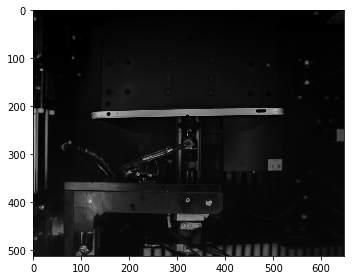

(1, 512, 648, 2)


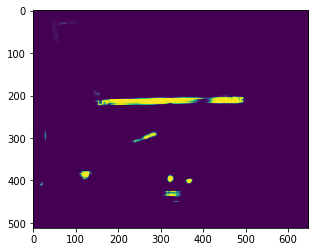

(3786, 3)


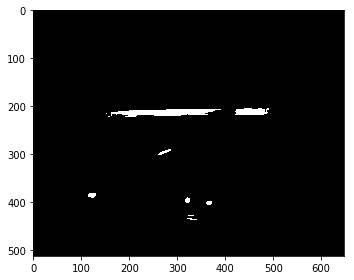

(2048, 2592)
(512, 648)
1
(1, 512, 648, 1)
(1, 512, 648, 1)


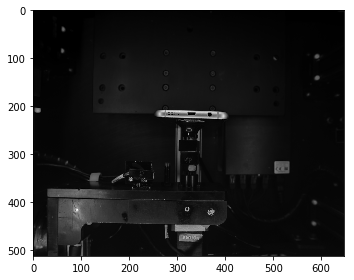

(1, 512, 648, 2)


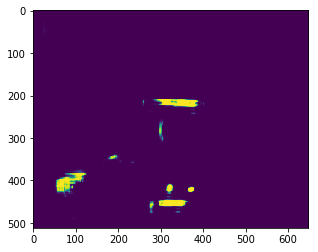

(3160, 3)


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


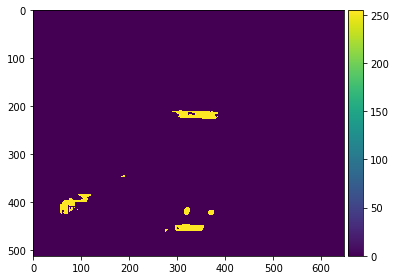

(2048, 2592)
(512, 648)
2
(1, 512, 648, 1)
(1, 512, 648, 1)


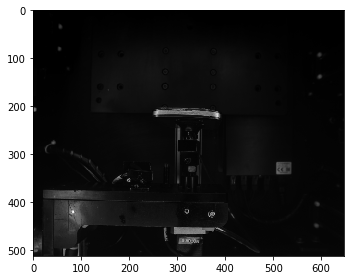

(1, 512, 648, 2)


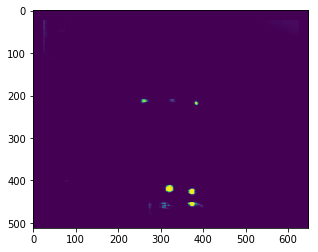

(337, 3)


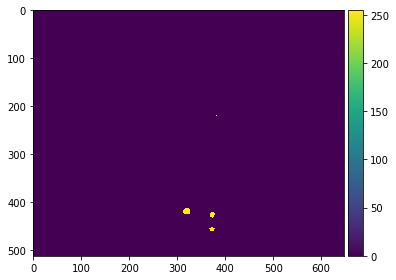

(2048, 2592)
(512, 648)
3
(1, 512, 648, 1)
(1, 512, 648, 1)


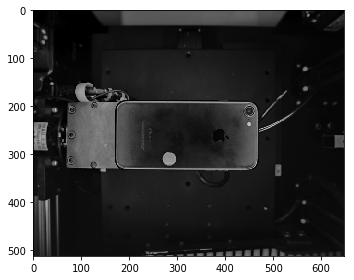

(1, 512, 648, 2)


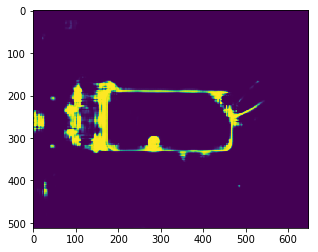

(10174, 3)


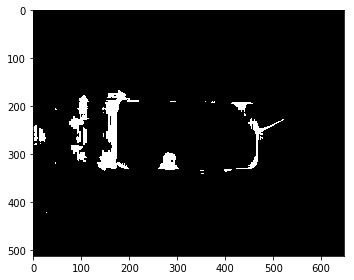

(2048, 2592)
(512, 648)
4
(1, 512, 648, 1)
(1, 512, 648, 1)


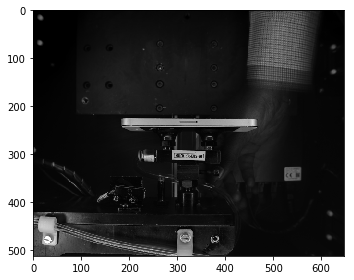

(1, 512, 648, 2)


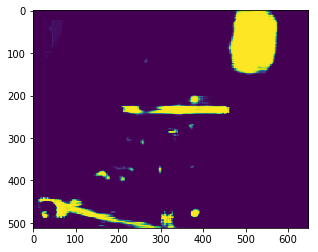

(20160, 3)


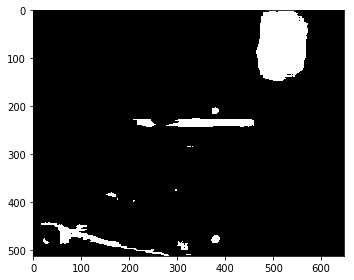

(2048, 2592)
(512, 648)
5
(1, 512, 648, 1)
(1, 512, 648, 1)


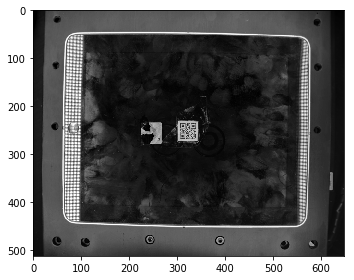

(1, 512, 648, 2)


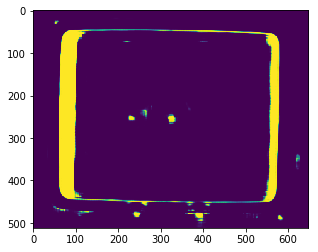

(24041, 3)


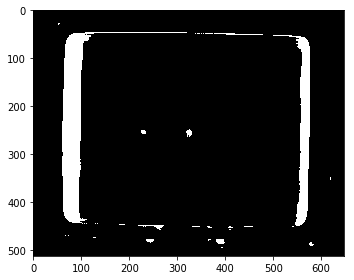

(2048, 2592)
(512, 648)
6
(1, 512, 648, 1)
(1, 512, 648, 1)


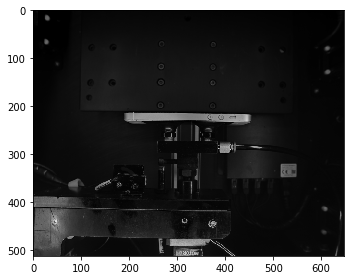

(1, 512, 648, 2)


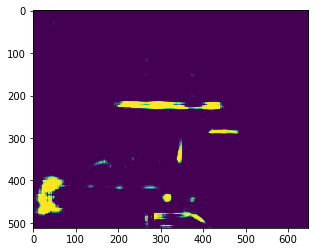

(6805, 3)


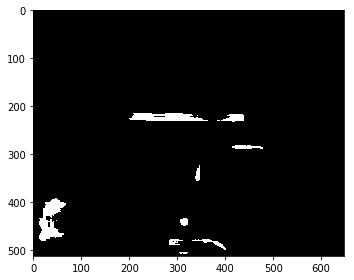

(2048, 2592)
(512, 648)
7
(1, 512, 648, 1)
(1, 512, 648, 1)


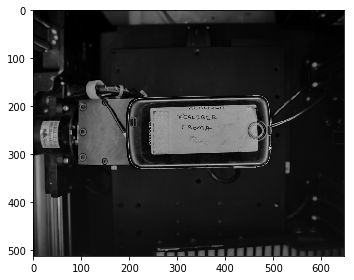

(1, 512, 648, 2)


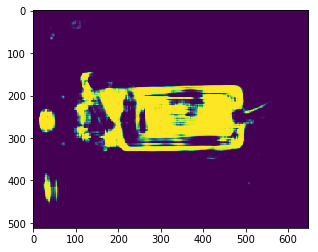

(35484, 3)


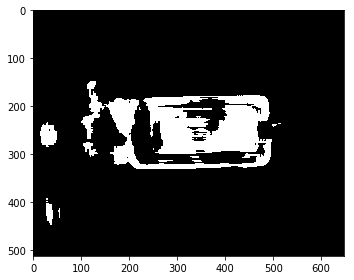

(2048, 2592)
(512, 648)
8
(1, 512, 648, 1)
(1, 512, 648, 1)


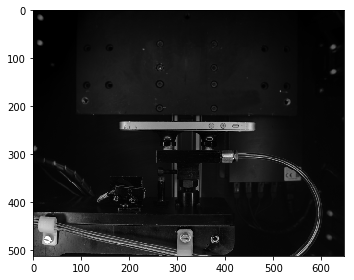

(1, 512, 648, 2)


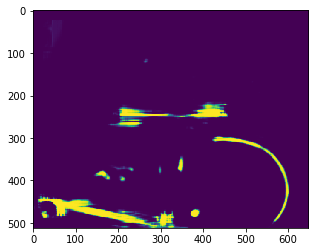

(8673, 3)


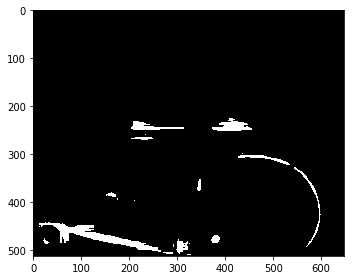

(2048, 2592)
(512, 648)
9
(1, 512, 648, 1)
(1, 512, 648, 1)


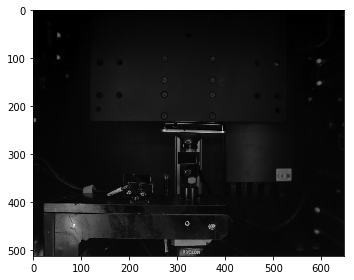

(1, 512, 648, 2)


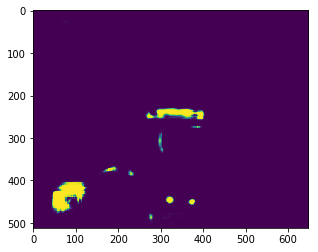

(4581, 3)


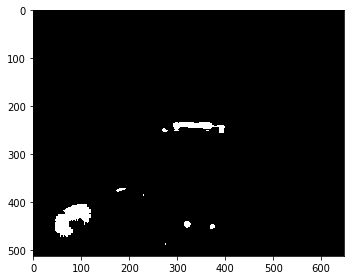

(2048, 2592)
(512, 648)
10
(1, 512, 648, 1)
(1, 512, 648, 1)


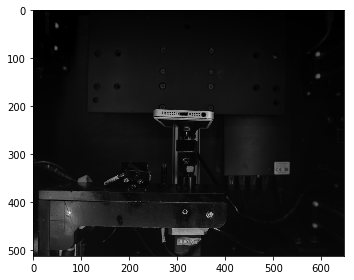

(1, 512, 648, 2)


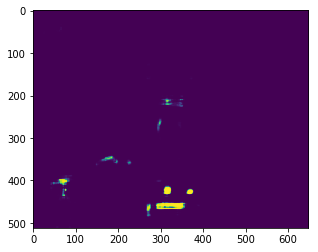

(1159, 3)


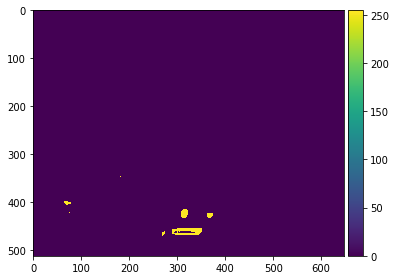

(2048, 2592)
(512, 648)
11
(1, 512, 648, 1)
(1, 512, 648, 1)


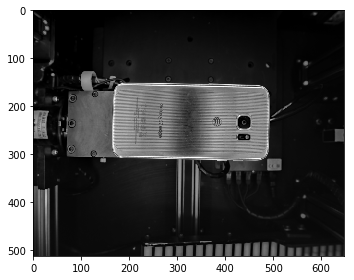

(1, 512, 648, 2)


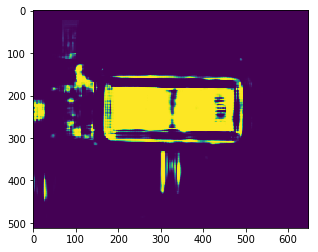

(32976, 3)


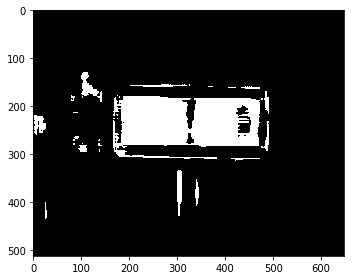

(2048, 2592)
(512, 648)
12
(1, 512, 648, 1)
(1, 512, 648, 1)


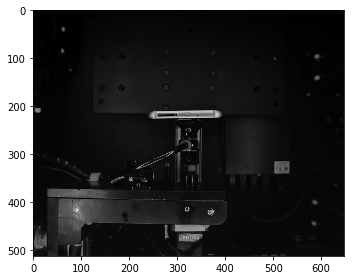

(1, 512, 648, 2)


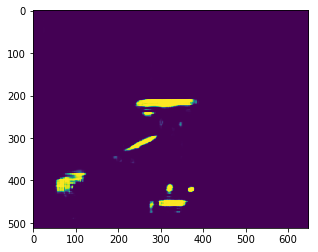

(4590, 3)


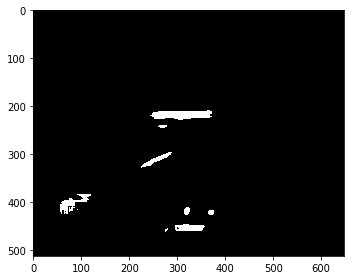

(2048, 2592)
(512, 648)
13
(1, 512, 648, 1)
(1, 512, 648, 1)


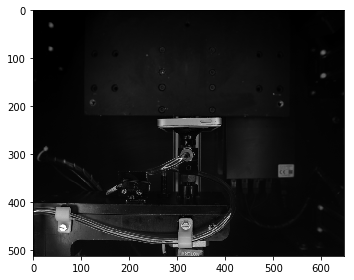

(1, 512, 648, 2)


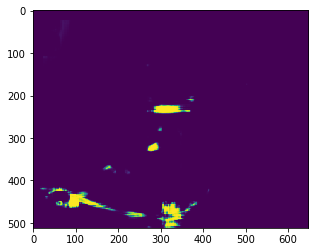

(3517, 3)


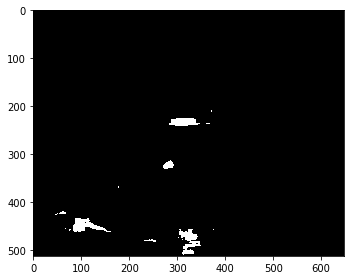

(2048, 2592)
(512, 648)
14
(1, 512, 648, 1)
(1, 512, 648, 1)


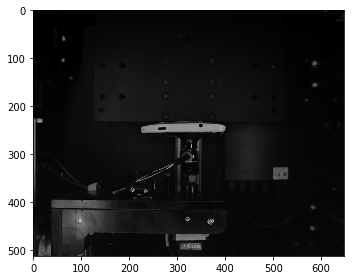

(1, 512, 648, 2)


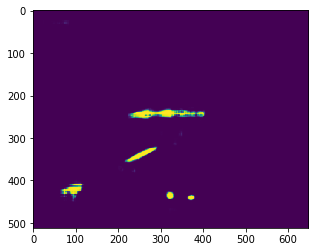

(2266, 3)


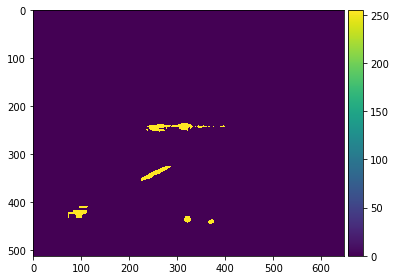

(2048, 2592)
(512, 648)
15
(1, 512, 648, 1)
(1, 512, 648, 1)


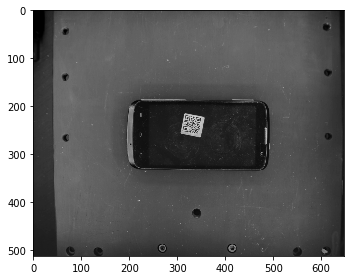

(1, 512, 648, 2)


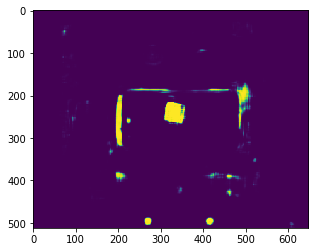

(4130, 3)


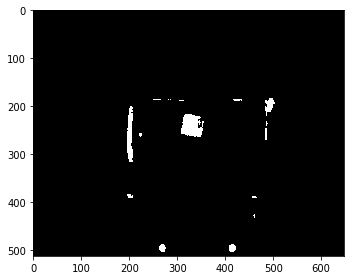

(2048, 2592)
(512, 648)
16
(1, 512, 648, 1)
(1, 512, 648, 1)


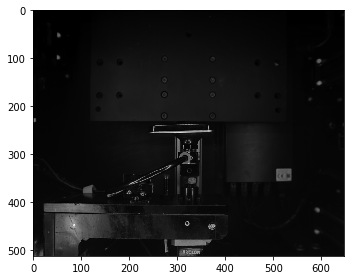

(1, 512, 648, 2)


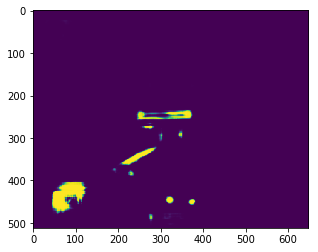

(4680, 3)


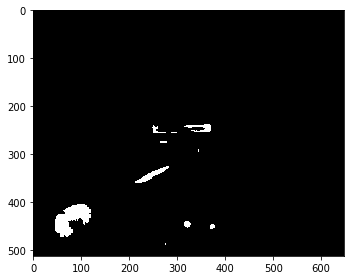

(2048, 2592)
(512, 648)
17
(1, 512, 648, 1)
(1, 512, 648, 1)


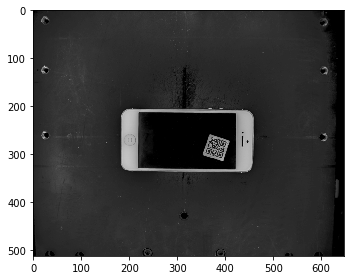

(1, 512, 648, 2)


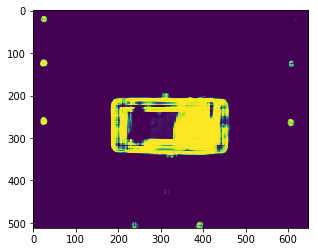

(22953, 3)


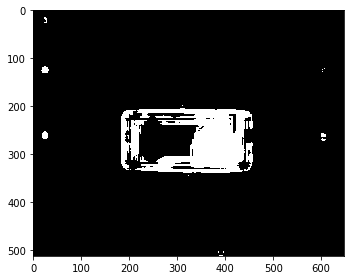

(2048, 2592)
(512, 648)
18
(1, 512, 648, 1)
(1, 512, 648, 1)


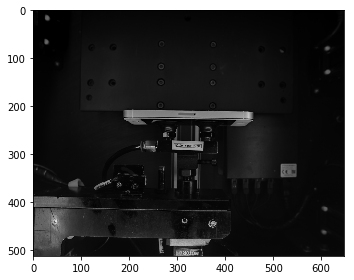

(1, 512, 648, 2)


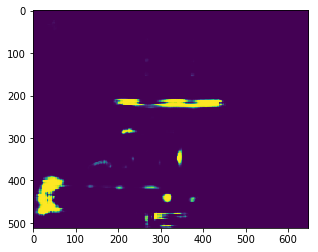

(5939, 3)


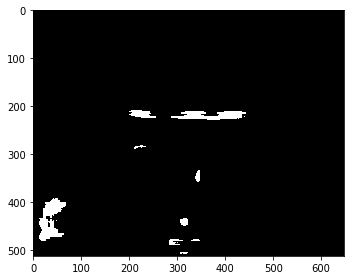

(2048, 2592)
(512, 648)
19
(1, 512, 648, 1)
(1, 512, 648, 1)


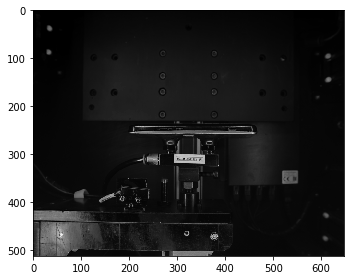

(1, 512, 648, 2)


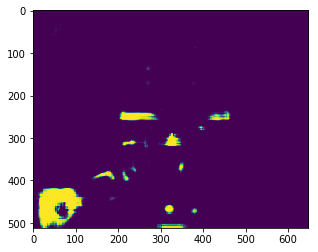

(7839, 3)


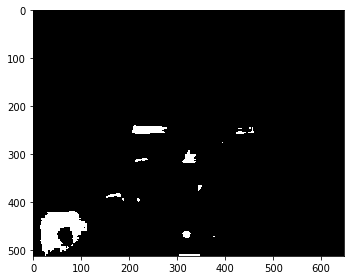

(2048, 2592)
(512, 648)
20
(1, 512, 648, 1)
(1, 512, 648, 1)


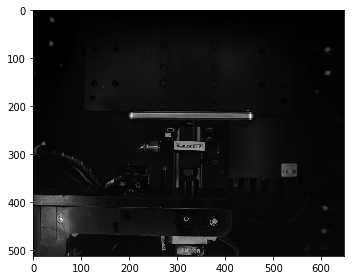

(1, 512, 648, 2)


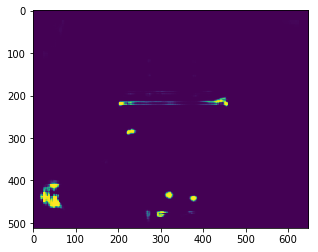

(1394, 3)


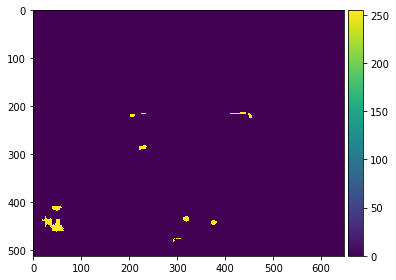

(2048, 2592)
(512, 648)
21
(1, 512, 648, 1)
(1, 512, 648, 1)


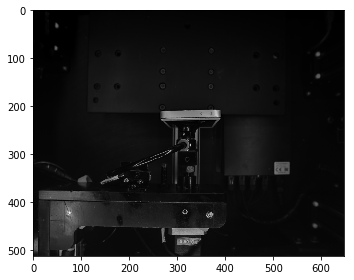

(1, 512, 648, 2)


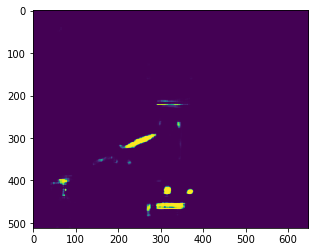

(1814, 3)


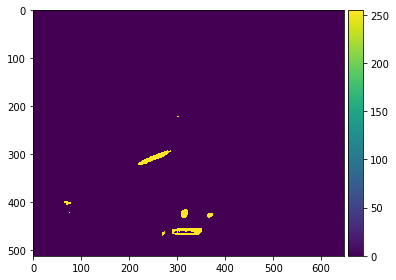

(2048, 2592)
(512, 648)
22
(1, 512, 648, 1)
(1, 512, 648, 1)


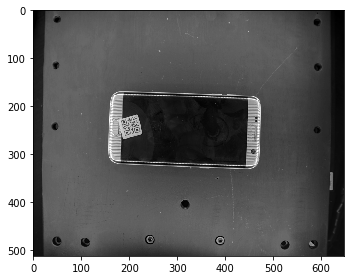

(1, 512, 648, 2)


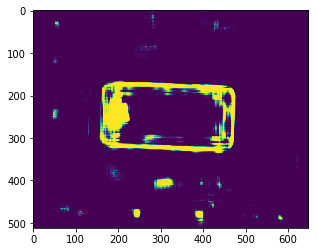

(14892, 3)


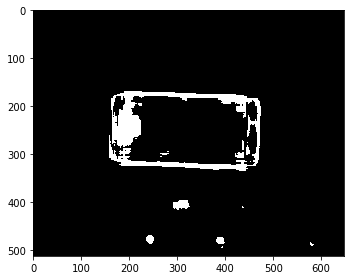

(2048, 2592)
(512, 648)
23
(1, 512, 648, 1)
(1, 512, 648, 1)


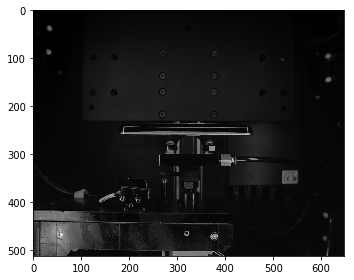

(1, 512, 648, 2)


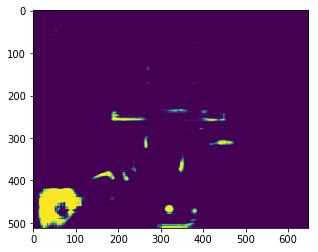

(6596, 3)


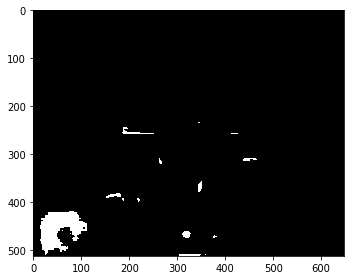

(2048, 2592)
(512, 648)
24
(1, 512, 648, 1)
(1, 512, 648, 1)


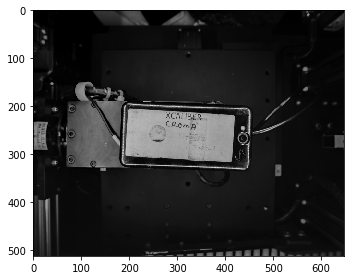

(1, 512, 648, 2)


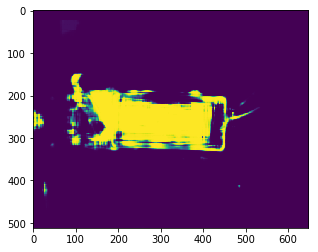

(30906, 3)


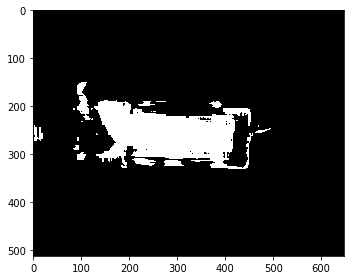

(2048, 2592)
(512, 648)
25
(1, 512, 648, 1)
(1, 512, 648, 1)


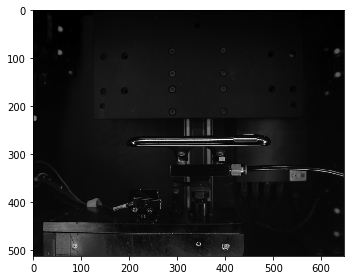

(1, 512, 648, 2)


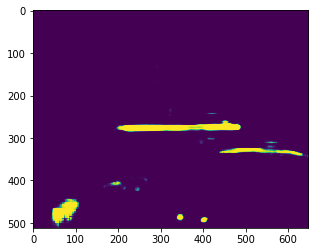

(6792, 3)


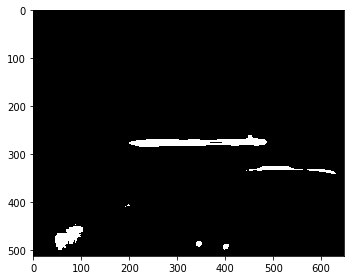

(2048, 2592)
(512, 648)
26
(1, 512, 648, 1)
(1, 512, 648, 1)


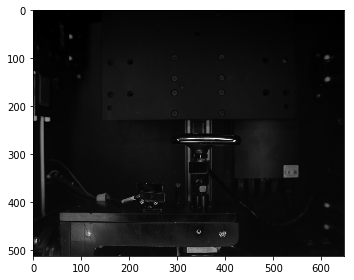

(1, 512, 648, 2)


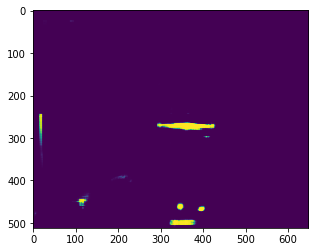

(2166, 3)


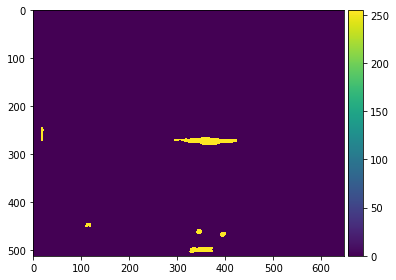

(2048, 2592)
(512, 648)
27
(1, 512, 648, 1)
(1, 512, 648, 1)


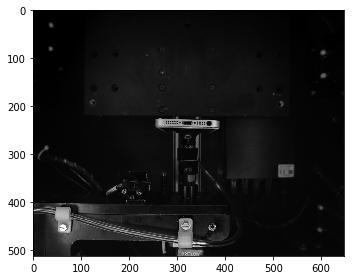

(1, 512, 648, 2)


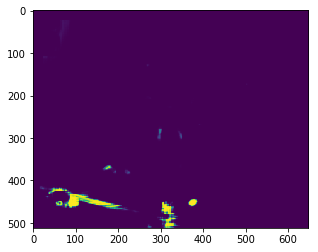

(1928, 3)


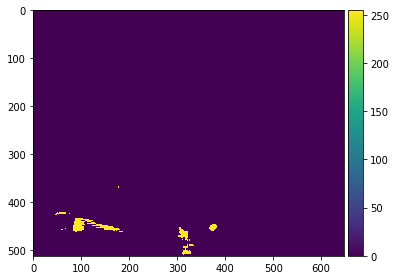

(2048, 2592)
(512, 648)
28
(1, 512, 648, 1)
(1, 512, 648, 1)


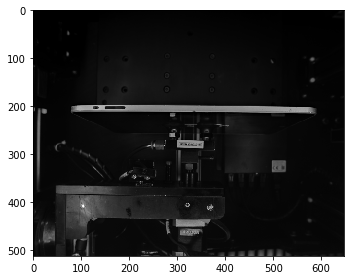

(1, 512, 648, 2)


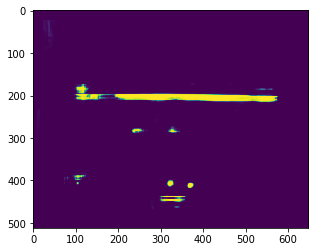

(5971, 3)


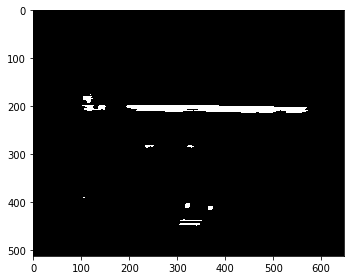

(2048, 2592)
(512, 648)
29
(1, 512, 648, 1)
(1, 512, 648, 1)


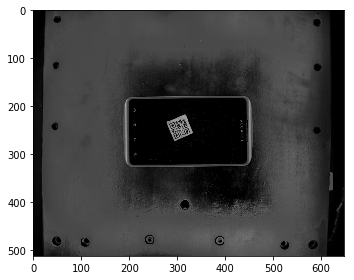

(1, 512, 648, 2)


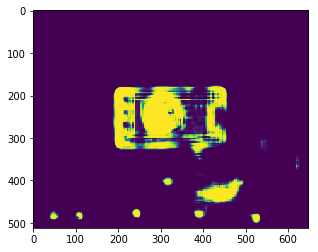

(22403, 3)


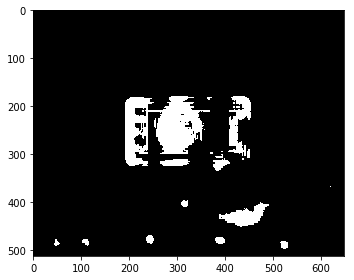

(2048, 2592)
(512, 648)
30
(1, 512, 648, 1)
(1, 512, 648, 1)


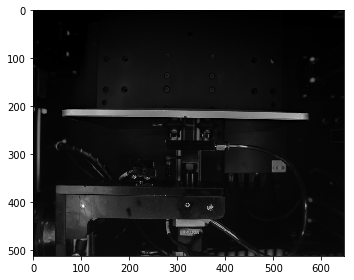

(1, 512, 648, 2)


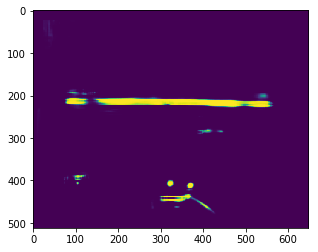

(5944, 3)


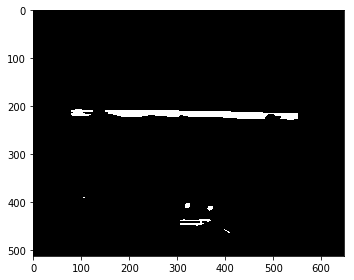

(2048, 2592)
(512, 648)
31
(1, 512, 648, 1)
(1, 512, 648, 1)


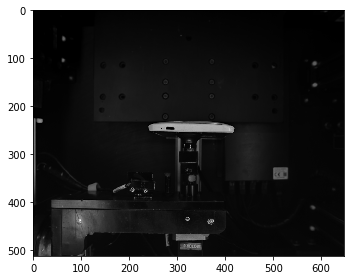

(1, 512, 648, 2)


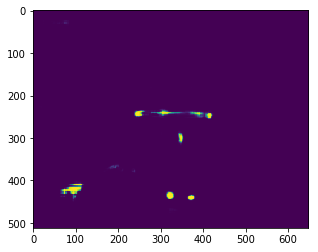

(988, 3)


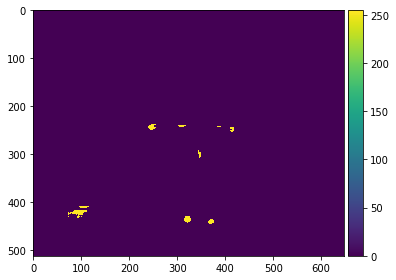

(2048, 2592)
(512, 648)
32
(1, 512, 648, 1)
(1, 512, 648, 1)


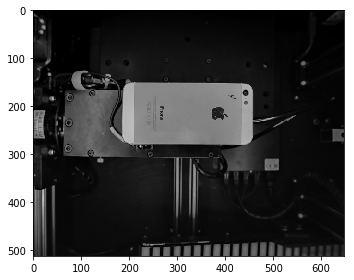

(1, 512, 648, 2)


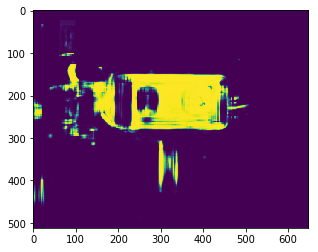

(28871, 3)


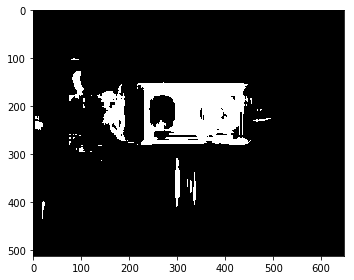

(2048, 2592)
(512, 648)
33
(1, 512, 648, 1)
(1, 512, 648, 1)


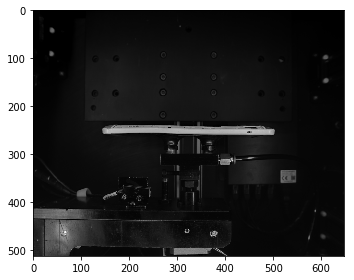

(1, 512, 648, 2)


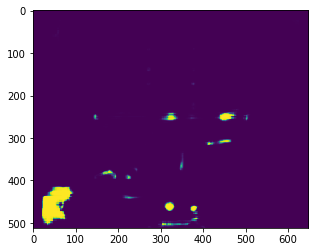

(4225, 3)


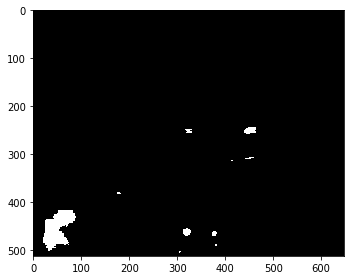

(2048, 2592)
(512, 648)
34
(1, 512, 648, 1)
(1, 512, 648, 1)


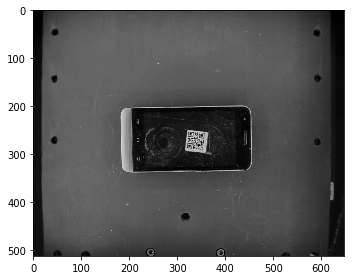

(1, 512, 648, 2)


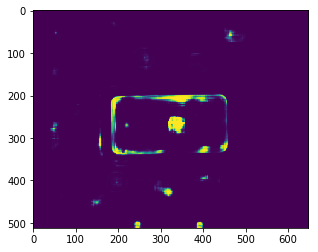

(3016, 3)


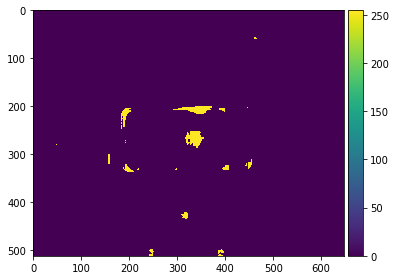

(2048, 2592)
(512, 648)
35
(1, 512, 648, 1)
(1, 512, 648, 1)


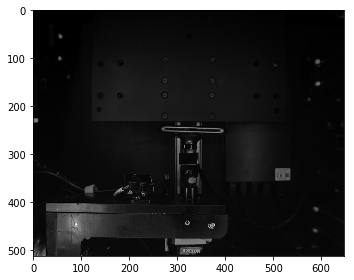

(1, 512, 648, 2)


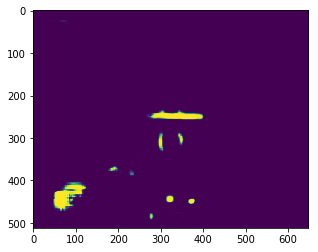

(3568, 3)


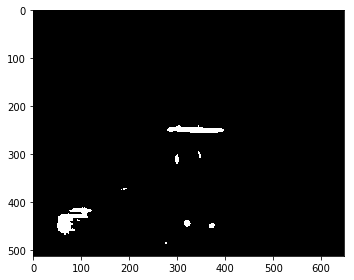

(2048, 2592)
(512, 648)
36
(1, 512, 648, 1)
(1, 512, 648, 1)


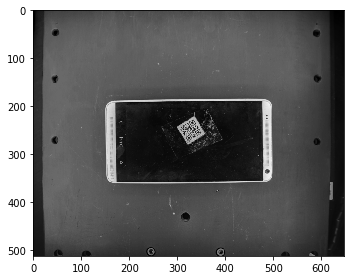

(1, 512, 648, 2)


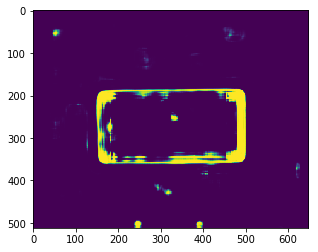

(10458, 3)


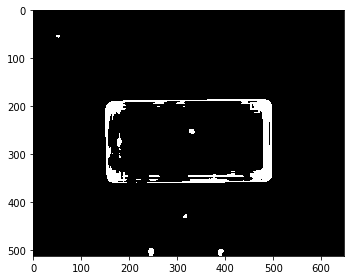

(2048, 2592)
(512, 648)
37
(1, 512, 648, 1)
(1, 512, 648, 1)


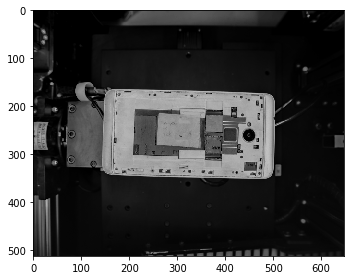

(1, 512, 648, 2)


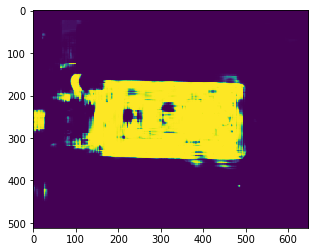

(59479, 3)


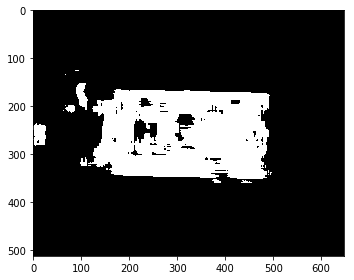

(2048, 2592)
(512, 648)
38
(1, 512, 648, 1)
(1, 512, 648, 1)


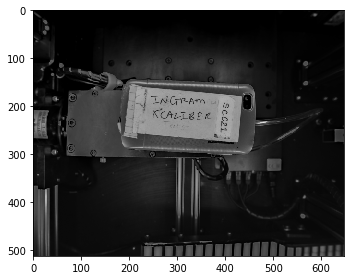

(1, 512, 648, 2)


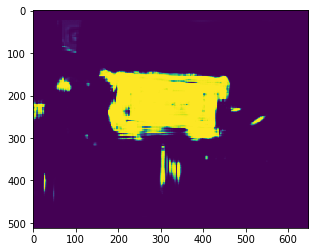

(35697, 3)


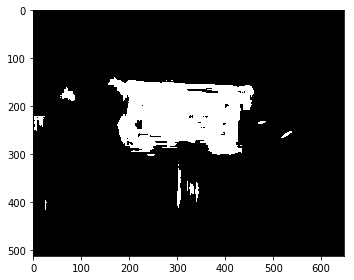

(2048, 2592)
(512, 648)
39
(1, 512, 648, 1)
(1, 512, 648, 1)


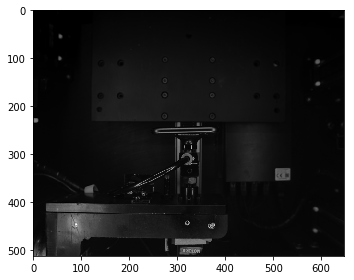

(1, 512, 648, 2)


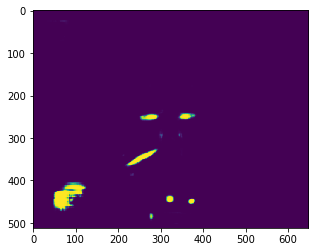

(3134, 3)


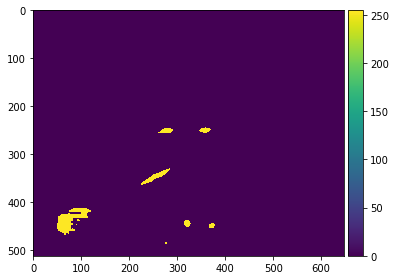

(2048, 2592)
(512, 648)
40
(1, 512, 648, 1)
(1, 512, 648, 1)


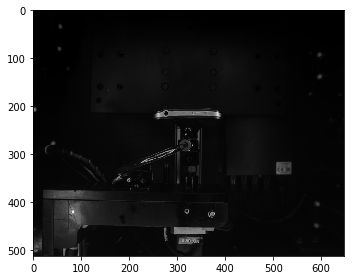

(1, 512, 648, 2)


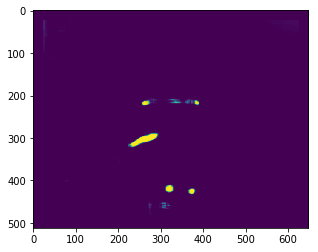

(1051, 3)


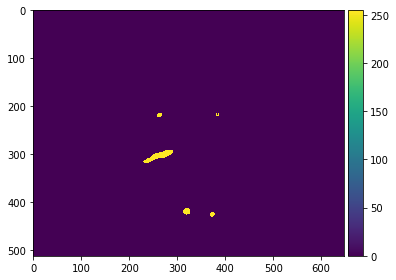

(2048, 2592)
(512, 648)
41
(1, 512, 648, 1)
(1, 512, 648, 1)


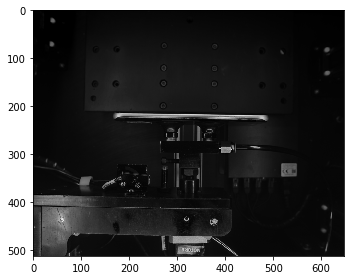

(1, 512, 648, 2)


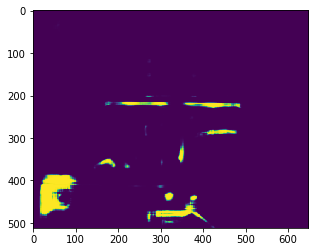

(7565, 3)


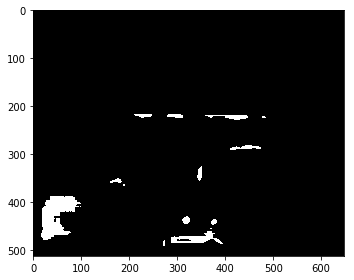

(2048, 2592)
(512, 648)
42
(1, 512, 648, 1)
(1, 512, 648, 1)


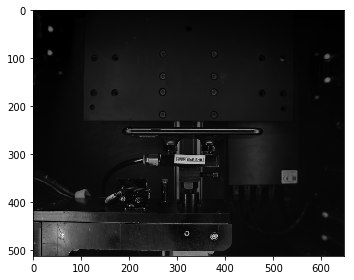

(1, 512, 648, 2)


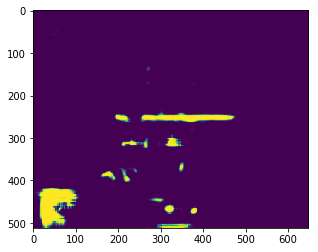

(8520, 3)


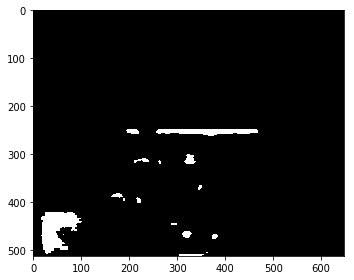

(2048, 2592)
(512, 648)
43
(1, 512, 648, 1)
(1, 512, 648, 1)


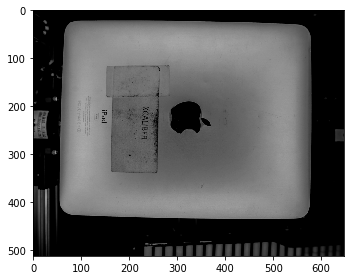

(1, 512, 648, 2)


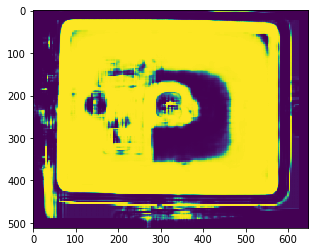

(175843, 3)


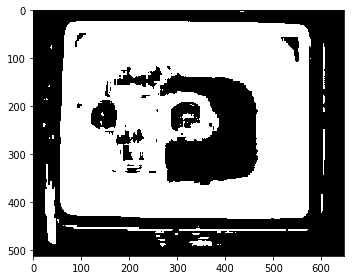

(2048, 2592)
(512, 648)
44
(1, 512, 648, 1)
(1, 512, 648, 1)


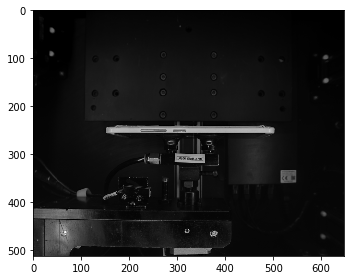

(1, 512, 648, 2)


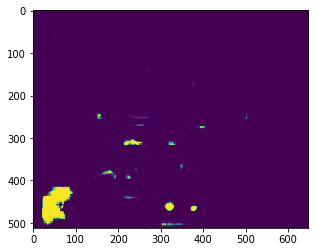

(4000, 3)


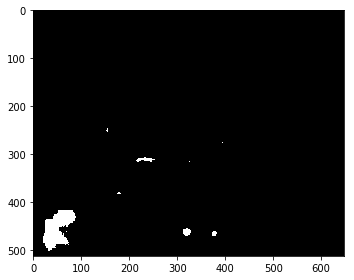

(2048, 2592)
(512, 648)
45
(1, 512, 648, 1)
(1, 512, 648, 1)


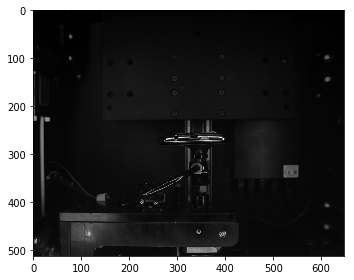

(1, 512, 648, 2)


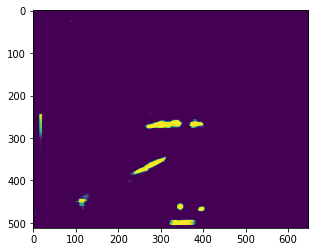

(2601, 3)


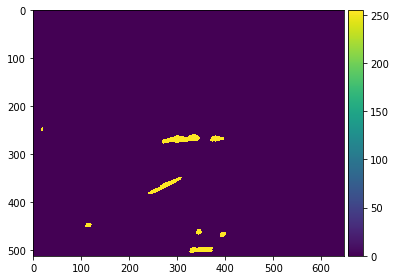

(2048, 2592)
(512, 648)
46
(1, 512, 648, 1)
(1, 512, 648, 1)


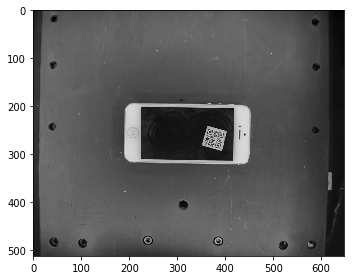

(1, 512, 648, 2)


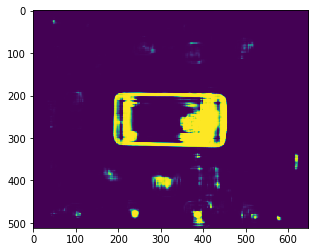

(15995, 3)


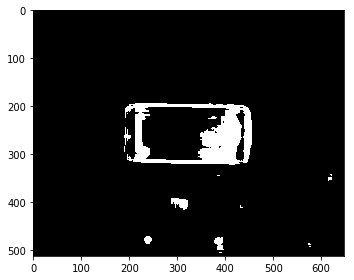

(2048, 2592)
(512, 648)
47
(1, 512, 648, 1)
(1, 512, 648, 1)


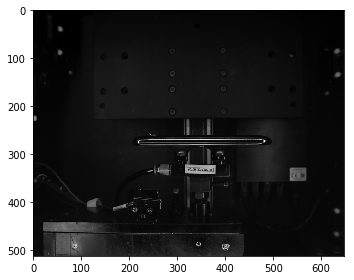

(1, 512, 648, 2)


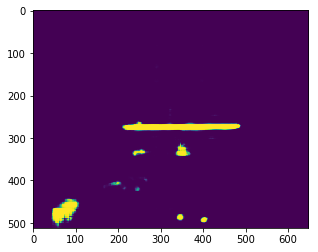

(6094, 3)


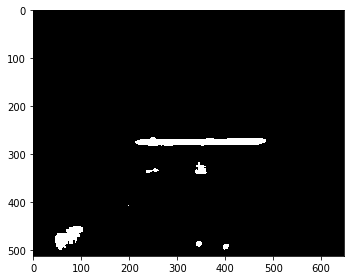

(2048, 2592)
(512, 648)
48
(1, 512, 648, 1)
(1, 512, 648, 1)


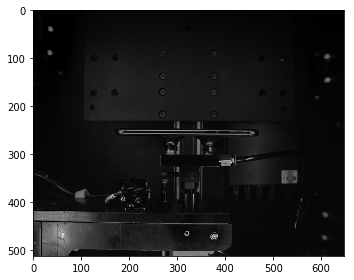

(1, 512, 648, 2)


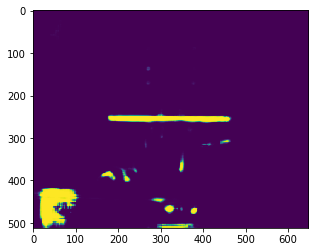

(8568, 3)


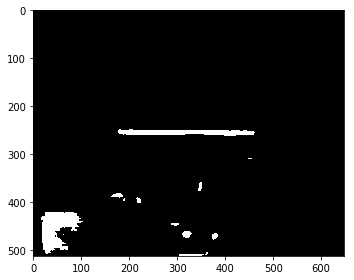

(2048, 2592)
(512, 648)
49
(1, 512, 648, 1)
(1, 512, 648, 1)


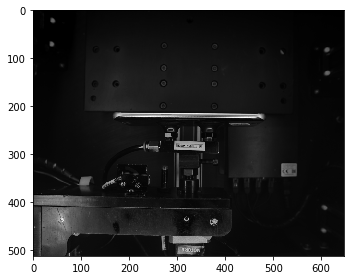

(1, 512, 648, 2)


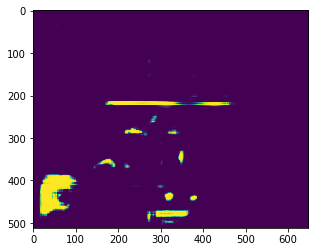

(7682, 3)


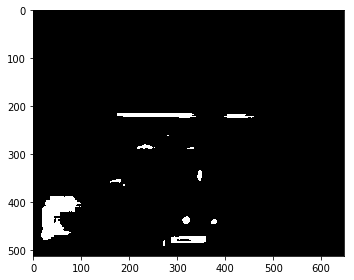

(2048, 2592)
(512, 648)
50
(1, 512, 648, 1)
(1, 512, 648, 1)


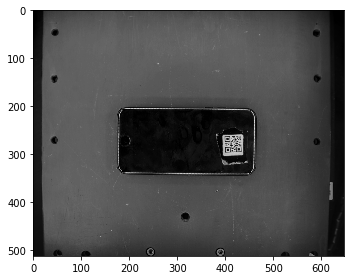

(1, 512, 648, 2)


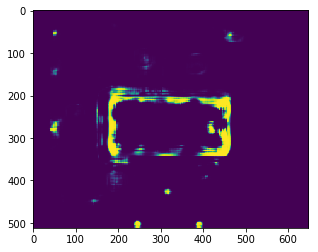

(6376, 3)


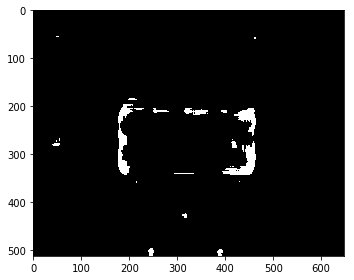

(2048, 2592)
(512, 648)
51
(1, 512, 648, 1)
(1, 512, 648, 1)


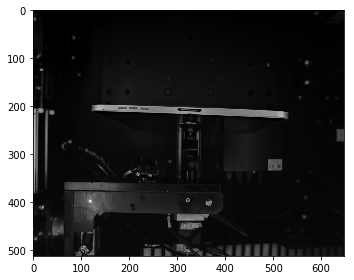

(1, 512, 648, 2)


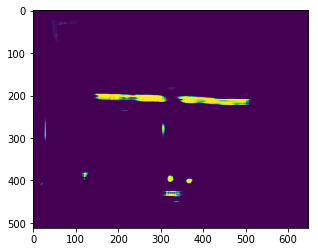

(3410, 3)


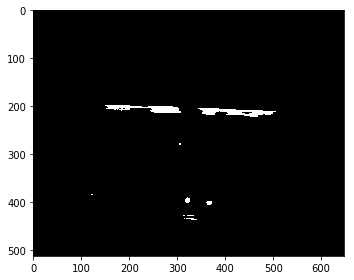

(2048, 2592)
(512, 648)
52
(1, 512, 648, 1)
(1, 512, 648, 1)


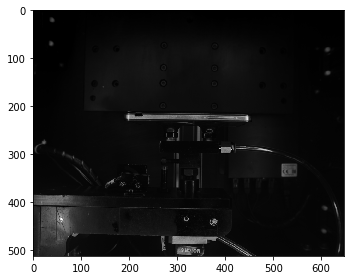

(1, 512, 648, 2)


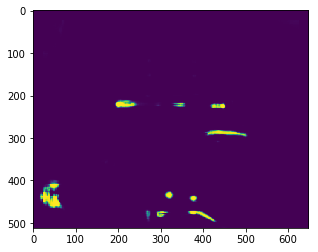

(2140, 3)


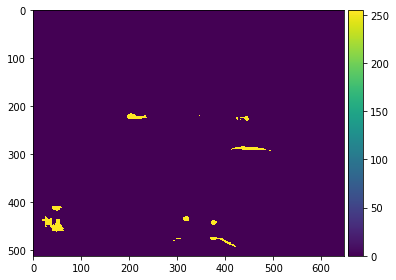

In [63]:
from skimage import io as skio
import matplotlib.pyplot as io
from glob import glob
import cv2 as cv
testPath = glob('/home/ubuntu/Desktop/DataAnnotated10/JPEGImages/**.png')
for i in range(len(testPath)):
  
    img1 = skio.imread(testPath[i])
    img = skio.imread(testPath[i],as_grey=True)
    print(img.shape)
    img = np.asarray(img).astype('float32')
    img = cv.resize(img,dsize=(324*2,256*2),interpolation=cv.INTER_AREA)
    print(img.shape)
    #label = cv.resize(label,dsize=(324,256))
    print(i)
    #label = label.astype('uint8')
    img = img.reshape(1,256*2,324*2,1)
    print(img.shape)
    img = img/255.
    #label = label.reshape(512,648,1)
    print(img.shape)
    skio.imshow(img[0,:,:,0])
    skio.show()
    #img = (img-np.mean(img))/np.std(img)
    predicted = model.predict(img)
    print(predicted.shape)
    io.imshow(predicted[0,:,:,1])
    
    io.show()
    thresh = np.argwhere(predicted[:,:,:,1]>0.9)
    img = np.zeros((256*2,324*2)).astype('uint8')
    print(thresh.shape)
    for i in range(thresh.shape[0]):
        img[thresh[i][1],thresh[i][2]]=255
        
        
    skio.imshow(img)
    skio.show()

In [ ]:
img = img.reshape(256,324)

In [ ]:
imgss = cv.resize(img,(2592,2048),interpolation=cv.INTER_AREA)

In [ ]:
img  = img/255.
img = (img-np.mean(img))/np.std(img)

In [ ]:
io.imshow(imgss)
io.show()
io.imshow(img1)
io.show()

In [ ]:
ones = np.argwhere(imgss==255)

In [ ]:
model.evaluate(train,labels,batch_size=1,verbose=1)

In [ ]:
twos = np.argwhere(labels==2)

In [ ]:
for i in range(twos.shape[0]):
    labels[twos[i][0],twos[i][1],twos[i][2],0] = 1
    print(i)

In [ ]:
np.save(arr=labels,file='/home/ubuntu/MobileExtraction/Labels512x648.npy')

In [ ]:
np.mean(train)

In [ ]:
predicted.shape

In [ ]:
x = np.argwhere(predicted[0,:,:,1]<predicted[0,:,:,0])

In [ ]:
x.shape

In [ ]:
()x

In [ ]:
img = np.zeros((256,324)).astype('float32')

In [ ]:
for i in range(x.shape[0]):
    img[x[0],x[1]]=255

In [ ]:
np.argwhere(x>0)

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 324, 1)  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 324, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 324, 64) 36928       conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 162, 64) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 

RuntimeError: You tried to call `count_params` on conv2d_40, but the layer isn't built. You can build it manually via: `conv2d_40.build(batch_input_shape)`.

In [ ]:
img = skio.imread(testPath[i])

In [ ]:
img.shape

In [ ]:
len(ones)

In [ ]:
imgss.shape

In [ ]:
img1.shape

In [ ]:
z = img1/imgss


In [ ]:
io.imshow(z)